DL Project SimVp

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import os
os.chdir('/content/drive/My Drive')

In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [3]:
class VideoDataset(Dataset):
    def __init__(self, base_path, dataset_type='train', transform=None):
        self.base_path = base_path
        self.dataset_type = dataset_type
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        folder_path = os.path.join(self.base_path, self.dataset_type)
        for video_folder in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_folder)
            image_count = 21 if self.dataset_type == 'unlabeled' else 22
            images = [os.path.join(video_path, f'image_{i}.png') for i in range(0, image_count)]
            mask_path = os.path.join(video_path, 'mask.npy') if self.dataset_type != 'unlabeled' else None
            samples.append((images, mask_path))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_paths, mask_path = self.samples[idx]
        images = [Image.open(path) for path in image_paths]

        if self.transform is not None:
            images = [self.transform(image) for image in images]

        images = torch.stack(images)

        if mask_path:
            mask = np.load(mask_path)
            mask = torch.tensor(mask, dtype=torch.long)
        else:
            mask = torch.tensor([])

        return images, mask

In [4]:
# Base path for datasets
base_path = '../../dataset'  # Adjust this path

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add any other transformations here
])

In [ ]:
train_dataset = VideoDataset(base_path, dataset_type='train', transform=transform)
val_dataset = VideoDataset(base_path, dataset_type='val', transform=transform)
unlabeled_dataset = VideoDataset(base_path, dataset_type='unlabeled', transform=transform)

# Create DataLoaders for each dataset
unlabeled_loader = DataLoader(unlabeled_dataset,batch_size=4,shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Reference : SimVP - https://github.com/A4Bio/SimVP-Simpler-yet-Better-Video-Prediction/blob/master/modules.py

In [ ]:
from torch import nn


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, transpose=False, act_norm=False):
        super(BasicConv2d, self).__init__()
        self.act_norm=act_norm
        if not transpose:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,output_padding=stride //2 )
        self.norm = nn.GroupNorm(2, out_channels)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y


class ConvSC(nn.Module):
    def __init__(self, C_in, C_out, stride, transpose=False, act_norm=True):
        super(ConvSC, self).__init__()
        if stride == 1:
            transpose = False
        self.conv = BasicConv2d(C_in, C_out, kernel_size=3, stride=stride,
                                padding=1, transpose=transpose, act_norm=act_norm)

    def forward(self, x):
        y = self.conv(x)
        return y


class GroupConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups, act_norm=False):
        super(GroupConv2d, self).__init__()
        self.act_norm = act_norm
        if in_channels % groups != 0:
            groups = 1
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,groups=groups)
        self.norm = nn.GroupNorm(groups,out_channels)
        self.activate = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.activate(self.norm(y))
        return y


class Inception(nn.Module):
    def __init__(self, C_in, C_hid, C_out, incep_ker=[3,5,7,11], groups=8):
        super(Inception, self).__init__()
        self.conv1 = nn.Conv2d(C_in, C_hid, kernel_size=1, stride=1, padding=0)
        layers = []
        for ker in incep_ker:
            layers.append(GroupConv2d(C_hid, C_out, kernel_size=ker, stride=1, padding=ker//2, groups=groups, act_norm=True))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        y = 0
        for layer in self.layers:
            y += layer(x)
        return y

In [ ]:
import torch
from torch import nn


def stride_generator(N, reverse=False):
    strides = [1, 2]*10
    if reverse: return list(reversed(strides[:N]))
    else: return strides[:N]

class Encoder(nn.Module):
    def __init__(self,C_in, C_hid, N_S):
        super(Encoder,self).__init__()
        strides = stride_generator(N_S)
        self.enc = nn.Sequential(
            ConvSC(C_in, C_hid, stride=strides[0]),
            *[ConvSC(C_hid, C_hid, stride=s) for s in strides[1:]]
        )

    def forward(self,x):# B*4, 3, 128, 128
        enc1 = self.enc[0](x)
        latent = enc1
        for i in range(1,len(self.enc)):
            latent = self.enc[i](latent)
        return latent,enc1


class Decoder(nn.Module):
    def __init__(self,C_hid, C_out, N_S):
        super(Decoder,self).__init__()
        strides = stride_generator(N_S, reverse=True)
        self.dec = nn.Sequential(
            *[ConvSC(C_hid, C_hid, stride=s, transpose=True) for s in strides[:-1]],
            ConvSC(2*C_hid, C_hid, stride=strides[-1], transpose=True)
        )
        self.readout = nn.Conv2d(C_hid, C_out, 1)

    def forward(self, hid, enc1=None):
        for i in range(0,len(self.dec)-1):
            hid = self.dec[i](hid)
        Y = self.dec[-1](torch.cat([hid, enc1], dim=1))
        Y = self.readout(Y)
        return Y

class Mid_Xnet(nn.Module):
    def __init__(self, channel_in, channel_hid, N_T, incep_ker = [3,5,7,11], groups=8):
        super(Mid_Xnet, self).__init__()

        self.N_T = N_T
        enc_layers = [Inception(channel_in, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            enc_layers.append(Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        enc_layers.append(Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))

        dec_layers = [Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            dec_layers.append(Inception(2*channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        dec_layers.append(Inception(2*channel_hid, channel_hid//2, channel_in, incep_ker= incep_ker, groups=groups))

        self.enc = nn.Sequential(*enc_layers)
        self.dec = nn.Sequential(*dec_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.reshape(B, T*C, H, W)

        # encoder
        skips = []
        z = x
        for i in range(self.N_T):
            z = self.enc[i](z)
            if i < self.N_T - 1:
                skips.append(z)

        # decoder
        z = self.dec[0](z)
        for i in range(1, self.N_T):
            z = self.dec[i](torch.cat([z, skips[-i]], dim=1))

        y = z.reshape(B, T, C, H, W)
        return y


class SimVP(nn.Module):
    def __init__(self, shape_in, hid_S=16, hid_T=256, N_S=4, N_T=8, incep_ker=[3,5,7,11], groups=8):
        super(SimVP, self).__init__()
        T, C, H, W = shape_in
        self.enc = Encoder(C, hid_S, N_S)
        self.hid = Mid_Xnet(T*hid_S, hid_T, N_T, incep_ker, groups)
        self.dec = Decoder(hid_S, C, N_S)


    def forward(self, x_raw):
        B, T, C, H, W = x_raw.shape
        x = x_raw.reshape(B*T, C, H, W)

        embed, skip = self.enc(x)
        _, C_, H_, W_ = embed.shape

        z = embed.view(B, T, C_, H_, W_)
        hid = self.hid(z)
        hid = hid.reshape(B*T, C_, H_, W_)

        Y = self.dec(hid, skip)
        Y = Y.reshape(B, T, C, H, W)
        return Y

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as cal_ssim

def MAE(pred, true):
    return np.mean(np.abs(pred-true),axis=(0,1)).sum()

def MSE(pred, true):
    return np.mean((pred-true)**2,axis=(0,1)).sum()

# cite the `PSNR` code from E3d-LSTM, Thanks!
# https://github.com/google/e3d_lstm/blob/master/src/trainer.py line 39-40
def PSNR(pred, true):
    mse = np.mean((np.uint8(pred * 255)-np.uint8(true * 255))**2)
    return 20 * np.log10(255) - 10 * np.log10(mse)

def metric(pred, true, mean, std, return_ssim_psnr=False, clip_range=[0, 1]):
    pred = pred*std + mean
    true = true*std + mean
    mae = MAE(pred, true)
    mse = MSE(pred, true)

    if return_ssim_psnr:
        pred = np.maximum(pred, clip_range[0])
        pred = np.minimum(pred, clip_range[1])
        ssim, psnr = 0, 0
        for b in range(pred.shape[0]):
            for f in range(pred.shape[1]):
                ssim += cal_ssim(pred[b, f].swapaxes(0, 2), true[b, f].swapaxes(0, 2), multichannel=True)
                psnr += PSNR(pred[b, f], true[b, f])
        ssim = ssim / (pred.shape[0] * pred.shape[1])
        psnr = psnr / (pred.shape[0] * pred.shape[1])
        return mse, mae, ssim, psnr
    else:
        return mse, mae

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

epochs=1
shape_in = (11, 3, 128, 128)  # You need to adjust these dimensions based on your actual data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model
model = SimVP(shape_in=shape_in).to(device)
model.train()

frame_prediction_criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# OneCycleLR Scheduler
total_steps = epochs * len(train_loader)  # Total number of training steps
scheduler = OneCycleLR(optimizer, max_lr=0.01, total_steps=total_steps)

for epoch in range(epochs):
    for batch in unlabeled_loader:
        images, _ = batch
        input_frames = images[:, :11].to(device)
        target_frame = images[:, 21].to(device)

        # Forward pass
        predicted_frames = model(input_frames)
        predicted_target_frame = predicted_frames[:, -1]

        # Loss computation
        loss = frame_prediction_criterion(predicted_target_frame, target_frame)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the learning rate
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Step [{scheduler.last_epoch}/{total_steps}], Loss: {loss.item()}, LR: {scheduler.get_last_lr()[0]}")
    for batch in train_loader:
        images, _ = batch
        input_frames = images[:, :11].to(device)
        target_frame = images[:, 21].to(device)

        # Forward pass
        predicted_frames = model(input_frames)
        predicted_target_frame = predicted_frames[:, -1]

        # Loss computation
        loss = frame_prediction_criterion(predicted_target_frame, target_frame)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the learning rate
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Step [{scheduler.last_epoch}/{total_steps}], Loss: {loss.item()}, LR: {scheduler.get_last_lr()[0]}")

Using device: cuda:0
Epoch [1/1], Step [1/250], Loss: 0.32194292545318604, LR: 0.0004043249622175272
Epoch [1/1], Step [2/250], Loss: 0.22402368485927582, LR: 0.0004172920549958721
Epoch [1/1], Step [3/250], Loss: 0.10666711628437042, LR: 0.00043887791075739035
Epoch [1/1], Step [4/250], Loss: 0.06263955682516098, LR: 0.00046904363033099805
Epoch [1/1], Step [5/250], Loss: 0.04304048418998718, LR: 0.0005077348530511047
Epoch [1/1], Step [6/250], Loss: 0.03118308261036873, LR: 0.0005548818547192035
Epoch [1/1], Step [7/250], Loss: 0.02431233413517475, LR: 0.0006103996732515944
Epoch [1/1], Step [8/250], Loss: 0.01989251933991909, LR: 0.0006741882617867945
Epoch [1/1], Step [9/250], Loss: 0.019762611016631126, LR: 0.0007461326689767542
Epoch [1/1], Step [10/250], Loss: 0.019644394516944885, LR: 0.0008261032461369475
Epoch [1/1], Step [11/250], Loss: 0.0239520613104105, LR: 0.0009139558808820714
Epoch [1/1], Step [12/250], Loss: 0.02254207618534565, LR: 0.0010095322568262968
Epoch [1/1], 

In [ ]:
model_save_path = 'my_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

# Inform the user
print(f'Model saved to {model_save_path}')

Model saved to my_model.pth


In [ ]:
from google.colab import files
model_save_path = 'my_model.pth'
#files.download(model_save_path)
shape_in = (11, 3, 128, 128)
print(f"Using device: {device}")
model = SimVP(shape_in=shape_in).to(device)

# Load the state dictionary
state_dict = torch.load('my_model.pth')

# Load the state dict into the model
model.load_state_dict(state_dict)

Using device: cuda:0


<All keys matched successfully>

In [ ]:
model.eval()
model.to(device)
mse_loss = nn.MSELoss()
total_loss = 0.0
with torch.no_grad():  # Disable gradient computation
    for batch in val_loader:
        images, _ = batch
        input_frames = images[:, :11].to(device)  # First 11 frames
        actual_22nd_frame = images[:, 21].to(device)
        # Forward pass to get the predictions
        predicted_frames = model(input_frames)
        predicted_22nd_frame = predicted_frames[:, -1]
        loss = mse_loss(predicted_22nd_frame, actual_22nd_frame)
        total_loss += loss.item()

# Calculate the average loss
average_loss = total_loss / len(val_loader)
print(f"Average MSE Loss on the validation dataset: {average_loss}")

KeyboardInterrupt: ignored

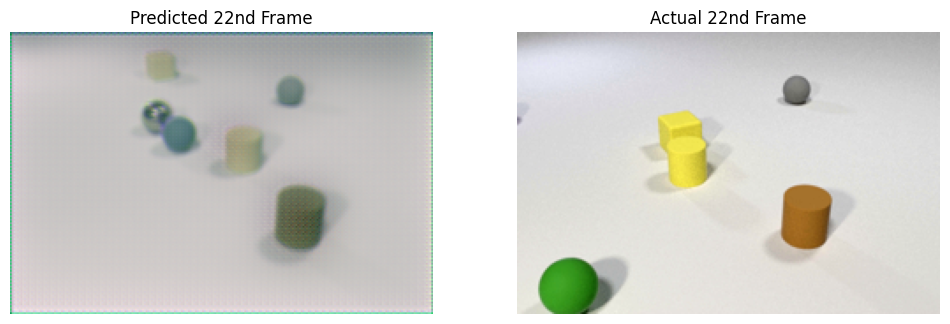

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

# Assuming the validation DataLoader and the trained model are already defined
# Load one batch from the validation dataset
batch = next(iter(val_loader))
input_frames, _ = batch
input_frames = input_frames.to(device)

# Predict the 22nd frame
model.eval()
with torch.no_grad():
    predicted_frames = model(input_frames[:, :11])  # Use first 11 frames as input
    predicted_22nd_frame = predicted_frames[:, -1]  # Extract the 22nd frame prediction

# Move tensors to CPU for plotting
predicted_22nd_frame = predicted_22nd_frame.cpu()
actual_22nd_frame = input_frames[:, 21].cpu()  # Actual 22nd frame

# Function to convert tensor to image
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = tensor.permute(1, 2, 0)  # Change dimensions from CxHxW to HxWxC
    tensor = tensor.numpy()
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())  # Normalize to [0, 1]
    return tensor

# Convert tensors to images
predicted_image = tensor_to_image(predicted_22nd_frame[0])  # First sample in the batch
actual_image = tensor_to_image(actual_22nd_frame[0])  # First sample in the batch

# Plot the images for comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(predicted_image)
plt.title('Predicted 22nd Frame')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(actual_image)
plt.title('Actual 22nd Frame')
plt.axis('off')

plt.show()


Semantic Segmentation

In [ ]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the U-Net model
n_channels = 3  # Assuming RGB images
n_classes = 49  # Update this based on your number of classes
modelunet = UNet(n_channels, n_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelunet.parameters(), lr=0.001)
# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Number of epochs
num_epochs = 1
total_steps = num_epochs * len(train_loader)

for epoch in range(num_epochs):
    modelunet.train()
    running_loss = 0.0

    # Training loop
    for images, masks in train_loader:
        # Assuming the input images are of shape (batch_size, frames, C, H, W)
        inputs = images[:, -1, :, :, :].to(device)
        #print(torch.unique(masks[0,0,:,:]))
        masks = masks[:, -1, :, :].to(device)  # Adjust dimensions if necessary
        #masks = torch.argmax(masks, dim=1)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = modelunet(inputs)
        print(f'Inputs Shape: {inputs.shape}')
        print(f'Masks Shape: {masks.shape}')
        print(f'Outputs Shape: {outputs.shape}')
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{scheduler.last_epoch}/{total_steps}], Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")

    # Print training statistics
    train_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}')

Inputs Shape: torch.Size([4, 3, 160, 240])
Masks Shape: torch.Size([4, 160, 240])
Outputs Shape: torch.Size([4, 49, 160, 240])
Epoch [1/1], Step [0/250], Loss: 3.9803178310394287, LR: 0.001
Inputs Shape: torch.Size([4, 3, 160, 240])
Masks Shape: torch.Size([4, 160, 240])
Outputs Shape: torch.Size([4, 49, 160, 240])
Epoch [1/1], Step [0/250], Loss: 3.72529673576355, LR: 0.001
Inputs Shape: torch.Size([4, 3, 160, 240])
Masks Shape: torch.Size([4, 160, 240])
Outputs Shape: torch.Size([4, 49, 160, 240])
Epoch [1/1], Step [0/250], Loss: 3.5780842304229736, LR: 0.001
Inputs Shape: torch.Size([4, 3, 160, 240])
Masks Shape: torch.Size([4, 160, 240])
Outputs Shape: torch.Size([4, 49, 160, 240])
Epoch [1/1], Step [0/250], Loss: 3.4688737392425537, LR: 0.001
Inputs Shape: torch.Size([4, 3, 160, 240])
Masks Shape: torch.Size([4, 160, 240])
Outputs Shape: torch.Size([4, 49, 160, 240])
Epoch [1/1], Step [0/250], Loss: 3.37673020362854, LR: 0.001
Inputs Shape: torch.Size([4, 3, 160, 240])
Masks Shape

KeyboardInterrupt: ignored

Image dataset class

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, base_path, dataset_type='train', transform=None):
        self.base_path = base_path
        self.dataset_type = dataset_type
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        folder_path = os.path.join(self.base_path, self.dataset_type)
        for video_folder in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_folder)
            mask_path = os.path.join(video_path, 'mask.npy') if self.dataset_type != 'unlabeled' else None

            # Loop to add all images from the folder
            for image_index in range(22):  # Assuming each folder has 22 images
                if image_index==21:
                  image_path = os.path.join(video_path, f'image_{image_index}.png')
                  samples.append((image_path, mask_path, image_index))

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, mask_path, image_index = self.samples[idx]
        image = Image.open(image_path)

        if self.transform is not None:
            image = self.transform(image)

        image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1)  # Assuming RGB

        if mask_path:
            mask = np.load(mask_path)
            mask = mask[image_index]  # Select the corresponding mask
            mask = torch.tensor(mask, dtype=torch.long)
        else:
            mask = torch.tensor([])

        return image, mask


In [ ]:
class ImageDatasettrainunet(Dataset):
    def __init__(self, base_path, dataset_type='train', transform=None):
        self.base_path = base_path
        self.dataset_type = dataset_type
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        folder_path = os.path.join(self.base_path, self.dataset_type)
        for video_folder in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_folder)
            mask_path = os.path.join(video_path, 'mask.npy') if self.dataset_type != 'unlabeled' else None

            # Loop to add all images from the folder
            for image_index in range(22):
              image_path = os.path.join(video_path, f'image_{image_index}.png')
              samples.append((image_path, mask_path, image_index))

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, mask_path, image_index = self.samples[idx]
        image = Image.open(image_path)

        if self.transform is not None:
            image = self.transform(image)

        image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1)  # Assuming RGB

        if mask_path:
            mask = np.load(mask_path)
            mask = mask[image_index]  # Select the corresponding mask
            mask = torch.tensor(mask, dtype=torch.long)
        else:
            mask = torch.tensor([])

        return image, mask

In [ ]:
train_dataset_image = ImageDatasettrainunet(base_path, dataset_type='train', transform=transform)
val_dataset_image = ImageDataset(base_path, dataset_type='val', transform=transform)

# Create DataLoaders for each dataset
train_loader_image = DataLoader(train_dataset_image, batch_size=32, shuffle=True)
val_loader_image = DataLoader(val_dataset_image, batch_size=32, shuffle=True)

In [ ]:
len(train_dataset_image)

22000

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Initialize the U-Net model
n_channels = 3  # Assuming RGB images
n_classes = 49  # Update this based on your number of classes
modelunet2 = UNet(n_channels, n_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelunet2.parameters(), lr=0.001)
# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Number of epochs
num_epochs = 5
total_steps = num_epochs * len(train_loader_image)

for epoch in range(num_epochs):
    modelunet2.train()
    running_loss = 0.0

    # Training loop
    for images, masks in train_loader_image:
        # Assuming the input images are of shape (batch_size, frames, C, H, W)
        #images = images.permute(0, 2, 1, 3)
        inputs = images.permute(0,2,3,1).to(device)
        #print(torch.unique(masks[0,0,:,:]))
        masks = masks.to(device)  # Adjust dimensions if necessary
        #masks = torch.argmax(masks, dim=1)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = modelunet2(inputs)
        #print(f'Inputs Shape: {inputs.shape}')
        #print(f'Masks Shape: {masks.shape}')
        #print(f'Outputs Shape: {outputs.shape}')
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        # Update the learning rate
        scheduler.step(loss)
        running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{scheduler.last_epoch}/{total_steps}], Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")

    # Print training statistics
    train_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}')

Epoch [1/5], Step [1/160], Loss: 4.041003704071045, LR: 0.001
Epoch [1/5], Step [2/160], Loss: 3.700505256652832, LR: 0.001
Epoch [1/5], Step [3/160], Loss: 3.479656934738159, LR: 0.001
Epoch [1/5], Step [4/160], Loss: 3.306318521499634, LR: 0.001
Epoch [1/5], Step [5/160], Loss: 3.187823534011841, LR: 0.001
Epoch [1/5], Step [6/160], Loss: 3.0828943252563477, LR: 0.001
Epoch [1/5], Step [7/160], Loss: 2.9794933795928955, LR: 0.001
Epoch [1/5], Step [8/160], Loss: 2.9268174171447754, LR: 0.001
Epoch [1/5], Step [9/160], Loss: 2.863004684448242, LR: 0.001
Epoch [1/5], Step [10/160], Loss: 2.7899558544158936, LR: 0.001
Epoch [1/5], Step [11/160], Loss: 2.7229857444763184, LR: 0.001
Epoch [1/5], Step [12/160], Loss: 2.669956922531128, LR: 0.001
Epoch [1/5], Step [13/160], Loss: 2.6062564849853516, LR: 0.001
Epoch [1/5], Step [14/160], Loss: 2.5451912879943848, LR: 0.001
Epoch [1/5], Step [15/160], Loss: 2.483628988265991, LR: 0.001
Epoch [1/5], Step [16/160], Loss: 2.4310503005981445, LR:

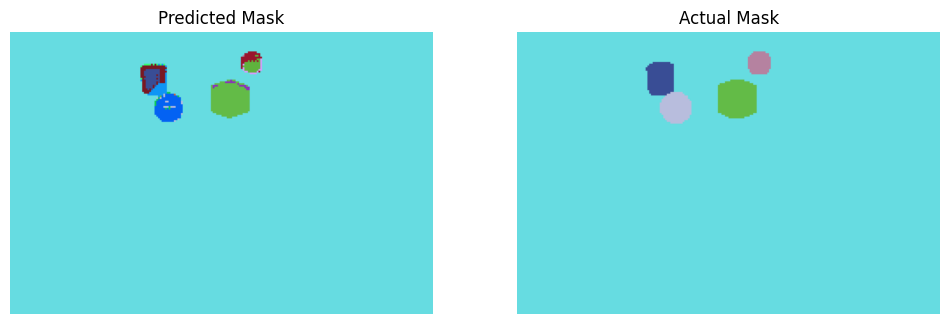

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to generate a color palette
def generate_palette(num_classes):
    np.random.seed(42)  # For reproducible colors
    palette = np.random.randint(0, 256, (num_classes, 3), dtype=np.uint8)
    return palette

# Function to convert mask indices to a color image
def mask_to_color(mask, palette):
    # Create an RGB image from the mask
    color_mask = palette[mask]
    return color_mask

# Generate a color palette for 49 classes
palette = generate_palette(49)


# Assuming 'model' is your trained U-Net model
modelunet2.eval()

with torch.no_grad():
    # Iterate through the validation dataset
    for i, (images, masks) in enumerate(val_loader_image):
        # Process one sample for demonstration purposes
        if i == 0:  # Adjust the index if you want to display a different sample
            # Ensure images are in the shape [batch_size, channels, height, width]
            images = images.permute(0, 2, 3, 1).to(device)

            # Predict the mask
            outputs = modelunet2(images)
            predicted_mask = torch.argmax(outputs, dim=1)[0]
            predicted_color_mask = mask_to_color(predicted_mask.cpu().numpy(), palette)

            # Actual mask
            actual_mask = masks[0].cpu().numpy()
            actual_color_mask = mask_to_color(actual_mask, palette)

            # Plotting
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(predicted_color_mask)
            axs[0].set_title('Predicted Mask')
            axs[0].axis('off')

            axs[1].imshow(actual_color_mask)
            axs[1].set_title('Actual Mask')
            axs[1].axis('off')

            plt.show()
            break


In [ ]:
total_images = 1000  # Total number of images
batch_size = 32      # Batch size from DataLoader
image_height, image_width = 160, 240  # Dimensions of the mask

# Tensor to store ground truth masks
ground_truth_masks = torch.zeros(total_images, image_height, image_width, dtype=torch.long)

with torch.no_grad():
    for i, (_, masks) in enumerate(val_loader_image):
        # Calculate the start index for this batch
        start_idx = i * batch_size

        # Calculate the end index for this batch
        end_idx = start_idx + masks.shape[0]

        # Store the ground truth masks for this batch
        ground_truth_masks[start_idx:end_idx] = masks

# Verify the shape of the ground truth masks tensor
print(ground_truth_masks.shape)  # Should be [1000, 160, 240]

torch.Size([1000, 160, 240])


In [ ]:
# Assuming 'model' is your trained U-Net model
modelunet2.eval()

# Total number of images and mask dimensions
total_images = 1000
image_height, image_width = 160, 240

# Tensor to store predictions
predicted_masks = torch.zeros(total_images, image_height, image_width, dtype=torch.long).to(device)

with torch.no_grad():
    for i, (images, _) in enumerate(val_loader_image):
        # Predict the masks for the batch
        images = images.permute(0, 2, 3, 1).to(device)  # Ensure correct shape [batch_size, channels, height, width]
        output = modelunet2(images)
        predicted_batch_masks = torch.argmax(output, dim=1)  # Convert to class indices

        # Calculate the start index for this batch
        start_idx = i * images.shape[0]  # images.shape[0] is the batch size

        # Calculate the end index for this batch
        end_idx = start_idx + images.shape[0]

        # Store the predictions in the tensor
        predicted_masks[start_idx:end_idx] = predicted_batch_masks

# Verify the shape of the predicted masks tensor
print(predicted_masks.shape)

torch.Size([1000, 160, 240])


In [ ]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
import torchmetrics

jaccard = torchmetrics.JaccardIndex(num_classes=49, task="multiclass").to(device)
iou_score = jaccard(predicted_masks, ground_truth_masks.to(device))

print(f"Jaccard Index for U-net(IoU) on validation: {iou_score}")

Jaccard Index (IoU): 0.019200319424271584


In [ ]:
model.eval()
model.to(device)
modelunet2.eval()

# Total number of videos and mask dimensions
total_videos = 1000
frame_height, frame_width = 160, 240

# Tensor to store predicted masks
predicted_masks_simvp = torch.zeros(total_videos, frame_height, frame_width, dtype=torch.long).to(device)

with torch.no_grad():
    for i, (videos, _) in enumerate(val_loader):
        # videos shape is expected to be [1, frames, channels, height, width]
        # Extract the first 11 frames
        predicted_frames = model(videos[:, :11].to(device))  # Use first 11 frames as input
        predicted_22nd_frame = predicted_frames[:, -1]  # Extract the 22nd frame prediction

        # Reshape or process predicted_22nd_frame as required by model_unet
        # Assuming model_unet expects [batch_size, channels, height, width]
        predicted_22nd_frame = predicted_22nd_frame.permute(0, 1,2, 3).to(device)

        # Predict the semantic mask of the predicted 22nd frame
        mask_output = modelunet2(predicted_22nd_frame)
        predicted_mask = torch.argmax(mask_output, dim=1).squeeze(0)

        # Store the predicted mask
        predicted_masks_simvp[i] = predicted_mask

# Verify the shape of the predicted masks tensor
print(predicted_masks_simvp.shape)  # Should be [1000, 160, 240]


KeyboardInterrupt: ignored

In [ ]:
jaccard = torchmetrics.JaccardIndex(num_classes=49, task="multiclass").to(device)
iou_score = jaccard(predicted_masks_simvp, ground_truth_masks.to(device))

print(f"Jaccard Index (IoU) for linked model on validation: {iou_score}")

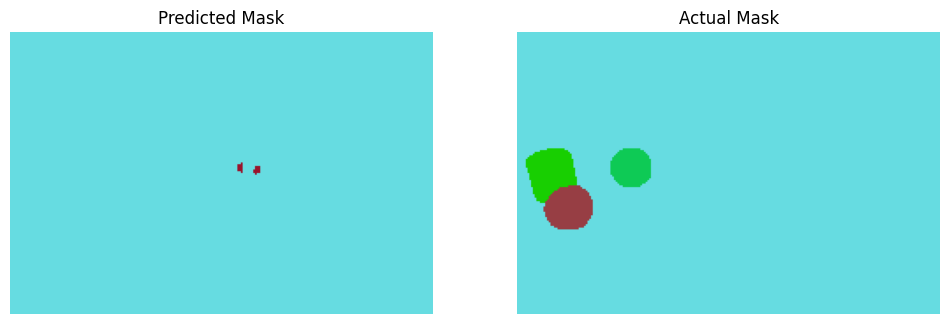

In [ ]:
model.eval()
model.to(device)
modelunet2.eval()

# Total number of videos and mask dimensions
total_videos = 1000
frame_height, frame_width = 160, 240
batch = next(iter(val_loader))
input_frames, maskstest = batch
input_frames = input_frames.to(device)

predicted_frames = model(input_frames[:, :11])  # Use first 11 frames as input
predicted_22nd_frame = predicted_frames[:, -1]  # Extract the 22nd frame prediction
predicted_22nd_frame = predicted_22nd_frame.permute(0, 1,2, 3).to(device)
 # Predict the mask
outputs = modelunet2(predicted_22nd_frame)
predicted_mask = torch.argmax(outputs, dim=1)[0]
predicted_color_mask = mask_to_color(predicted_mask.cpu().numpy(), palette)

# Actual mask
actual_mask = maskstest[:, -1, :, :].squeeze(0).cpu().numpy()
actual_color_mask = mask_to_color(actual_mask, palette)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(predicted_color_mask)
axs[0].set_title('Predicted Mask')
axs[0].axis('off')

axs[1].imshow(actual_color_mask)
axs[1].set_title('Actual Mask')
axs[1].axis('off')

plt.show()

In [ ]:
model.eval()
model.to(device)
modelunet2.eval()

# Total number of videos and mask dimensions
total_videos = 2000
frame_height, frame_width = 160, 240

# Tensor to store predicted masks
predicted_masks_simvp = torch.zeros(total_videos, frame_height, frame_width, dtype=torch.long).to(device)

with torch.no_grad():
    for i, (videos, _) in enumerate(hidden_loader):
        # videos shape is expected to be [1, frames, channels, height, width]
        # Extract the first 11 frames
        predicted_frames = model(videos[:, :11].to(device))  # Use first 11 frames as input
        predicted_22nd_frame = predicted_frames[:, -1]  # Extract the 22nd frame prediction

        # Reshape or process predicted_22nd_frame as required by model_unet
        # Assuming model_unet expects [batch_size, channels, height, width]
        predicted_22nd_frame = predicted_22nd_frame.permute(0, 1,2, 3).to(device)

        # Predict the semantic mask of the predicted 22nd frame
        mask_output = modelunet2(predicted_22nd_frame)
        predicted_mask = torch.argmax(mask_output, dim=1).squeeze(0)

        # Store the predicted mask
        predicted_masks_simvp[i] = predicted_mask

# Verify the shape of the predicted masks tensor
print(predicted_masks_simvp_hidden.shape)  # Should be [1000, 160, 240]
